In [1]:
!pip install torch torchvision torchaudio contractions
!pip install contractions
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
import string
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.utils import class_weight
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
nltk.download('punkt_tab')
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 1.Data

In [2]:
drive.mount('/content/drive')


# Accessing the dataset from my drive
olid_dataset_file_path = '/content/drive/MyDrive/NLP_2_CW/olid-training-v1.0.tsv'

# verify that file is exists or not
if os.path.exists(olid_dataset_file_path):
    print("OLID dataset found !!")
else :
    print("OLID dataset doesn't exist !!")


olid_dataset = pd.read_csv(olid_dataset_file_path,delimiter = '\t')

olid_dataset.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OLID dataset found !!


,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


### 1.1 Access Dataset And EDA

In [3]:
olid_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13240 non-null  int64 
 1   tweet      13240 non-null  object
 2   subtask_a  13240 non-null  object
 3   subtask_b  4400 non-null   object
 4   subtask_c  3876 non-null   object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


### 1.2 Understanding the output

In [4]:
olid_dataset['subtask_a'].unique()

array(['OFF', 'NOT'], dtype=object)

In [5]:
olid_dataset['subtask_b'].unique()

array(['UNT', 'TIN', nan], dtype=object)

### 1.3 Understanding Output Distribution

In [6]:
olid_dataset['subtask_a'].value_counts()

,count
subtask_a,
NOT,8840
OFF,4400


In [7]:
olid_dataset['subtask_b'].value_counts()

,count
subtask_b,
TIN,3876
UNT,524


### 1.4 Distribution of Output

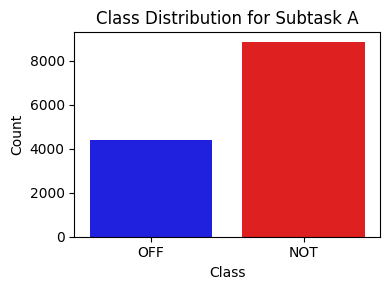

In [55]:
plt.figure(figsize=(4, 3))
sns.countplot(data=olid_dataset, hue='subtask_a',x='subtask_a', palette=['blue','red'])

plt.title('Class Distribution for Subtask A')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

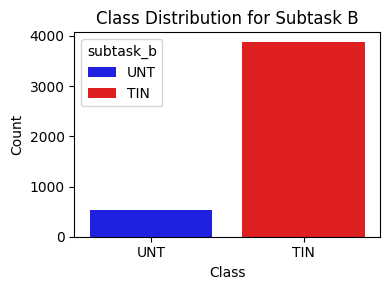

In [56]:
plt.figure(figsize=(4, 3))
sns.countplot(data=olid_dataset, hue='subtask_b',x='subtask_b', palette=['blue','red'])

plt.title('Class Distribution for Subtask B')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [10]:
# Extracting HTML entities
olid_dataset['html_entities_in_tweet'] = olid_dataset['tweet'].apply(lambda x: re.findall(r'&\w+;', x))

# Putting the list of lists into one list
all_entities = [entity for sublist in olid_dataset['html_entities_in_tweet'] for entity in sublist]

# Getting unique entities
unique_entities = set(all_entities)
print(unique_entities)

{'&amp;', '&gt;', '&lt;'}


#### 1.4.1 Avarage Word Length

In [11]:
all_words = " ".join(olid_dataset['tweet'].astype(str)).split()

# Calculate average word length
average_word_length = sum(len(word) for word in all_words) / len(all_words)

print("Average Word Length for the entire dataset:", average_word_length)

Average Word Length for the entire dataset: 4.670341353088158


#### 1.4.2 Word Count

In [12]:
olid_dataset['word_count'] = olid_dataset['tweet'].apply(lambda x: len(str(x).split()))

In [13]:
olid_dataset['word_count'].sum()

np.int64(295354)

### 1.5 Distribution of Tweet Lengths

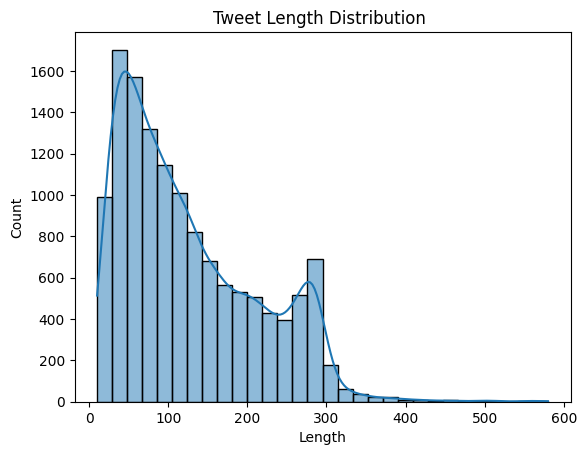

In [14]:
# Before Preprocessing
olid_dataset['tweet_length'] = olid_dataset['tweet'].apply(len)
sns.histplot(olid_dataset['tweet_length'], bins=30, kde=True)
plt.title('Length Distribution of tweets')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()


Distribution of Special Characters

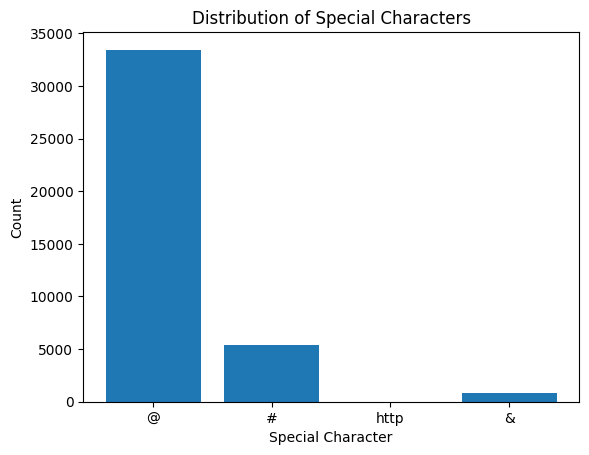

In [15]:
special_chars = ['@', '#', 'http', '&']  # adding necessary
special_char_counts = {char: 0 for char in special_chars}

for tweet in olid_dataset['tweet']:
    for char in special_chars:
        special_char_counts[char] += len(re.findall(re.escape(char), tweet))


plt.bar(special_char_counts.keys(), special_char_counts.values())
plt.title('Distribution of Special Characters')
plt.xlabel('Special Character')
plt.ylabel('Count')
plt.show()

### 1.6 Check Class Distribution

In [16]:
olid_dataset['subtask_a'].value_counts()

,count
subtask_a,
NOT,8840
OFF,4400


There is a class imbalance that affected the accuracy of our Subtask_a model so we will fix it by class weight method.  

##  Preprocessing Function




In [17]:
nltk.download('stopwords')

# Build a custom stopword list that preserves important words
default_stopwords = set(stopwords.words('english'))

# Words to keep in our domain (very important for this NLP task)
whitelist_words = {
    'i', 'you', 'he', 'she', 'we', 'they', 'it',
    'my', 'your', 'his', 'her', 'our', 'their',
    'is', 'am', 'are', 'was', 'were', 'be', 'being', 'been',
    'can', 'could', 'shall', 'should', 'would', 'will', 'might', 'must',
    'not', 'no', "n't", 'never'
}

# Final custom stopword list
custom_stopwords = default_stopwords - whitelist_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def preprocess_text(text):
    text = text.lower()

    # Remove mentions, hashtags, urls
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove HTML entities
    text = re.sub(r"&\w+;", "", text)

    # Remove emojis
    text = emoji.replace_emoji(text, replace='')

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization
    tokens = word_tokenize(text)

    # Stopword removal (custom list)
    tokens = [token for token in tokens if token not in custom_stopwords]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

## Apply Preprocessing to Dataset

In [19]:
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Apply preprocessing
tqdm.pandas()  # shows progress bar
olid_dataset['clean_tweet'] = olid_dataset['tweet'].progress_apply(lambda x: ' '.join(preprocess_text(x)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 13240/13240 [00:06<00:00, 2183.70it/s]


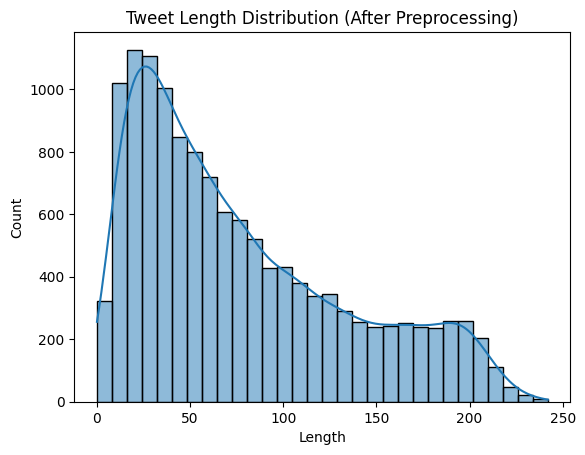

In [20]:
# After Preprocessing
olid_dataset['clean_tweet_length'] = olid_dataset['clean_tweet'].apply(len)
sns.histplot(olid_dataset['clean_tweet_length'], bins=30, kde=True)
plt.title('Tweet Length Distribution (After Preprocessing)')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

In [21]:
print("Original:", olid_dataset['tweet'][0])
print("Cleaned :", olid_dataset['clean_tweet'][0])


Original: @USER She should ask a few native Americans what their take on this is.
Cleaned : she should ask native american their take is


Most Frequent Words

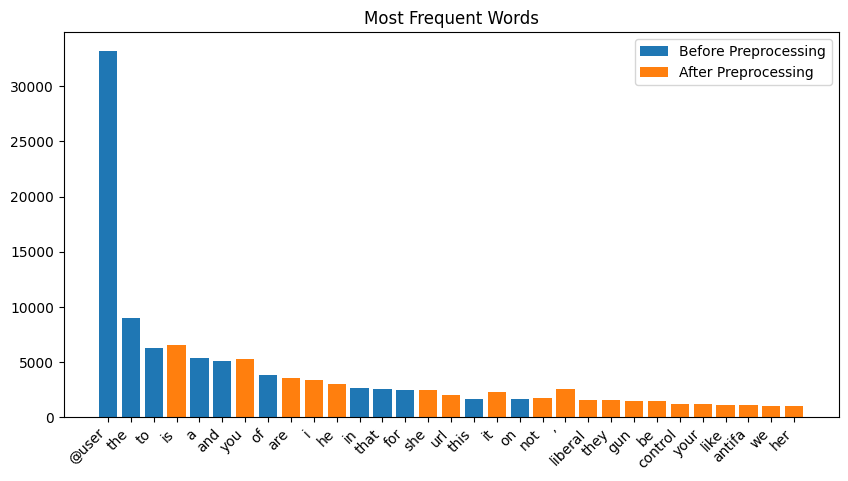

In [22]:
# Before Preprocessing
all_words = ' '.join(olid_dataset['tweet']).lower().split()
word_counts = Counter(all_words)
top_words = word_counts.most_common(20)  # Top 20 words

# After Preprocessing
all_clean_words = ' '.join(olid_dataset['clean_tweet']).lower().split()
clean_word_counts = Counter(all_clean_words)
top_clean_words = clean_word_counts.most_common(20)

# Plot (you can use bar charts or word clouds)
# Example for bar chart:
plt.figure(figsize=(10, 5))
plt.bar(*zip(*top_words), label='Before Preprocessing')
plt.bar(*zip(*top_clean_words), label='After Preprocessing')
plt.xticks(rotation=45, ha='right')
plt.title('Most Frequent Words')
plt.legend()
plt.show()

##  Step 3: Encode Labels for Subtask A

In [23]:
data = olid_dataset[['clean_tweet', 'subtask_a']].dropna()
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['subtask_a'])  # OFF = 1, NOT = 0

## Step 4: Tokenization & Padding

In [24]:
# Hyperparameters
vocab_size = 10000  # or higher
max_length = 50
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data['clean_tweet'].values)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['clean_tweet'].values)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

## Train-Test Split

In [25]:
X = padded_sequences
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 6: Build and Train LSTM Model for Subtask A
## Decliine the LSTM Model

In [26]:
embedding_dim = 128

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6614 - loss: 0.6466 - val_accuracy: 0.6755 - val_loss: 0.6328
Epoch 2/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6661 - loss: 0.6384 - val_accuracy: 0.6755 - val_loss: 0.6302
Epoch 3/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6711 - loss: 0.6387 - val_accuracy: 0.6755 - val_loss: 0.6301
Epoch 4/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6761 - loss: 0.6276 - val_accuracy: 0.6755 - val_loss: 0.6315
Epoch 5/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.6687 - loss: 0.6365 - val_accuracy: 0.6755 - val_loss: 0.6309


In [28]:
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model_lstm.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6565 - loss: 0.6468
Test Accuracy: 0.6545
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      1733
           1       0.00      0.00      0.00       915

    accuracy                           0.65      2648
   macro avg       0.33      0.50      0.40      2648
weighted avg       0.43      0.65      0.52      2648



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## EDA Step 1: Check Class Balance

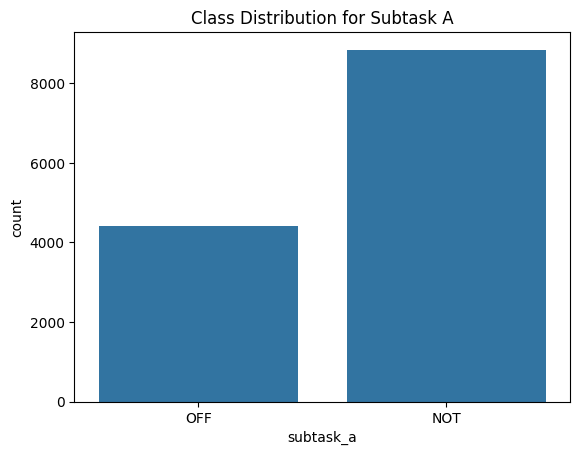

In [29]:
sns.countplot(x=data['subtask_a'])
plt.title("Class Distribution for Subtask A")
plt.show()

##  Step 2: Add Class Weights to Training

In [30]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.7451808076544252), 1: np.float64(1.5196556671449069)}


In [31]:
# Train with class weights to balance the loss
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=10,                     # increase if needed
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,   # <-- apply the weights
    verbose=1
)

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.5559 - loss: 0.7089 - val_accuracy: 0.6755 - val_loss: 0.6879
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.5927 - loss: 0.6800 - val_accuracy: 0.6868 - val_loss: 0.6345
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7706 - loss: 0.5684 - val_accuracy: 0.7170 - val_loss: 0.6122
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8578 - loss: 0.4007 - val_accuracy: 0.7292 - val_loss: 0.5866
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9093 - loss: 0.2877 - val_accuracy: 0.7179 - val_loss: 0.6655
Epoch 6/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9350 - loss: 0.2010 - val_accuracy: 0.7038 - val_loss: 0.8175
Epoch 7/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9567 - loss: 0.1436 - val_accuracy: 0.6811 - val_loss: 0.9590
Epoch 8/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9677 - loss: 0.1121 - 

## Balance class imbalance

In [32]:
# Train with class weights to balance the loss
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=10,                     # increase if needed
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,   # <-- apply the weights
    verbose=1
)

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9844 - loss: 0.0512 - val_accuracy: 0.6925 - val_loss: 1.4799
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9884 - loss: 0.0420 - val_accuracy: 0.7057 - val_loss: 1.5018
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9873 - loss: 0.0399 - val_accuracy: 0.6764 - val_loss: 1.7133
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9902 - loss: 0.0318 - val_accuracy: 0.6274 - val_loss: 1.8163
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9844 - loss: 0.0514 - val_accuracy: 0.7009 - val_loss: 1.7334
Epoch 6/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9891 - loss: 0.0336 - val_accuracy: 0.6604 - val_loss: 1.7623
Epoch 7/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9891 - loss: 0.0320 - val_accuracy: 0.6764 - val_loss: 1.8722
Epoch 8/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9911 - loss: 0.0243 - 

##  Define and Train BiLSTM Model

In [33]:
# BiLSTM Model
model_bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

# model_bilstm.summary()

# Train the model with class weights
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


298/298 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.5446 - loss: 0.6852 - val_accuracy: 0.6792 - val_loss: 0.6241
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.7884 - loss: 0.4955 - val_accuracy: 0.7453 - val_loss: 0.5343
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.8723 - loss: 0.3337 - val_accuracy: 0.7085 - val_loss: 0.6233
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9207 - loss: 0.2192 - val_accuracy: 0.6792 - val_loss: 0.7693
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9408 - loss: 0.1584 - val_accuracy: 0.7047 - val_loss: 0.8634
Epoch 6/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.9592 - loss: 0.1126 - val_accuracy: 0.7000 - val_loss: 1.0974
Epoch 7/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.9682 - loss: 0.0907 - val_accuracy: 0.6830 - val_loss: 1.3343
Epoch 8/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9761 - loss: 0.0692 - val_accurac

In [34]:
# Evaluate
loss, accuracy = model_bilstm.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict
y_pred_probs = model_bilstm.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7076 - loss: 1.5726
Test Accuracy: 0.7005
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1733
           1       0.56      0.63      0.59       915

    accuracy                           0.70      2648
   macro avg       0.67      0.68      0.68      2648
weighted avg       0.71      0.70      0.70      2648



In [35]:
# Assuming 'padded' is your padded sequences and 'y' is your labels
# Make sure these are defined and have the correct shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)  # Assuming you have X_test and y_test
print("y_test shape:", y_test.shape)  # Assuming you have X_test and y_test

vocab_size = 10000  # Keeping your original vocab_size
max_length = 50     # Keeping your original max_length

# BiLSTM Model (Modified)
model_bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])



# Callbacks (Added)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train the model with class weights and callbacks
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,  # or validation_data=(X_test, y_test) if you prefer
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],  # Added callbacks here
    verbose=1
)


X_train shape: (10592, 50)
y_train shape: (10592,)
X_test shape: (2648, 50)
y_test shape: (2648,)
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


298/298 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.5661 - loss: 0.6820 - val_accuracy: 0.7500 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.8037 - loss: 0.4600 - val_accuracy: 0.6840 - val_loss: 0.6178 - learning_rate: 0.0010
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.8609 - loss: 0.3244 - val_accuracy: 0.7189 - val_loss: 0.6230 - learning_rate: 0.0010
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9249 - loss: 0.2132 - val_accuracy: 0.7000 - val_loss: 0.7526 - learning_rate: 0.0010


## Convolutional Neural Network (CNN)

In [36]:
# CNN Model
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_cnn.summary()

# Train the model with class weights
history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5286 - loss: 0.6814 - val_accuracy: 0.7255 - val_loss: 0.6053
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8283 - loss: 0.4488 - val_accuracy: 0.7236 - val_loss: 0.5620
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9165 - loss: 0.2446 - val_accuracy: 0.7132 - val_loss: 0.7845
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9726 - loss: 0.0973 - val_accuracy: 0.7009 - val_loss: 0.9955
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9846 - loss: 0.0558 - val_accuracy: 0.7132 - val_loss: 1.2351
Epoch 6/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9923 - loss: 0.0359 - val_accuracy: 0.7226 - val_loss: 1.3893
Epoch 7/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9934 - loss: 0.0249 - val_accuracy: 0.7113 - val_loss: 1.4562
Epoch 8/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9938 - loss: 0.0223 - val_accu

In [37]:
# GRU Model
model_gru = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_gru.summary()

# Train the model with class weights
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4991 - loss: 0.6926 - val_accuracy: 0.3245 - val_loss: 0.7024
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.4904 - loss: 0.6949 - val_accuracy: 0.6755 - val_loss: 0.6736
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.4952 - loss: 0.6955 - val_accuracy: 0.6755 - val_loss: 0.6769
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.5620 - loss: 0.6949 - val_accuracy: 0.3245 - val_loss: 0.7107
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.4058 - loss: 0.6958 - val_accuracy: 0.6755 - val_loss: 0.6914
Epoch 6/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.5553 - loss: 0.6947 - val_accuracy: 0.6755 - val_loss: 0.6925
Epoch 7/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.4917 - loss: 0.6952 - val_accuracy: 0.6755 - val_loss: 0.6835
Epoch 8/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.5026 - loss: 0.6966 - 

In [38]:
# RCNN Model
model_rcnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_rcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_rcnn.summary()

# Train the model with class weights (if needed)
history_rcnn = model_rcnn.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.5421 - loss: 0.6822 - val_accuracy: 0.7462 - val_loss: 0.5569
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8053 - loss: 0.4570 - val_accuracy: 0.7434 - val_loss: 0.5483
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9078 - loss: 0.2620 - val_accuracy: 0.6726 - val_loss: 0.6755
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9514 - loss: 0.1538 - val_accuracy: 0.7217 - val_loss: 0.8865
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9698 - loss: 0.0934 - val_accuracy: 0.7208 - val_loss: 0.9430
Epoch 6/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9831 - loss: 0.0614 - val_accuracy: 0.7085 - val_loss: 1.2057
Epoch 7/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9841 - loss: 0.0516 - val_accuracy: 0.7057 - val_loss: 1.0622
Epoch 8/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9862 - loss: 0.0480 - val_acc

# Subtask B

## Filter Dataset for Subtask B

In [39]:
subtask_b_df = olid_dataset[olid_dataset['subtask_a'] == 'OFF'].copy()

# Optional: Drop NaN in subtask_b if any
subtask_b_df = subtask_b_df.dropna(subset=['subtask_b'])

# Check label distribution
print(subtask_b_df['subtask_b'].value_counts())


subtask_b
TIN    3876
UNT     524
Name: count, dtype: int64


<ipython-input-40-a63fd5a8f766>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='subtask_b', data=subtask_b_df, palette='Set2')


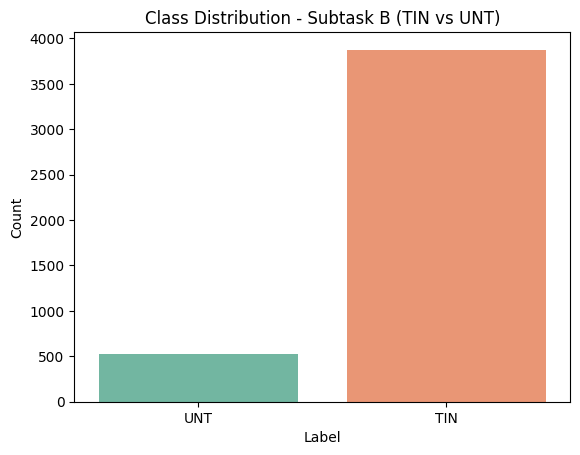

In [40]:
sns.countplot(x='subtask_b', data=subtask_b_df, palette='Set2')
plt.title('Class Distribution - Subtask B (TIN vs UNT)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


# 2. Encode Labels for TIN vs UNT

In [41]:
label_encoder_b = LabelEncoder()
subtask_b_df['label_b'] = label_encoder_b.fit_transform(subtask_b_df['subtask_b'])  # TIN=1, UNT=0


## 3. Text Tokenization + Padding

In [42]:
# Tokenize
tokenizer_b = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer_b.fit_on_texts(subtask_b_df['clean_tweet'])

# Convert text to sequences
sequences_b = tokenizer_b.texts_to_sequences(subtask_b_df['clean_tweet'])
padded_b = pad_sequences(sequences_b, maxlen=50)


 4. Split into Train & Validation

In [43]:
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(
    padded_b, subtask_b_df['label_b'], test_size=0.2, random_state=42)


##  5.  Show Example Input

In [44]:
print("Tweet:", subtask_b_df['tweet'].iloc[0])
print("Cleaned:", subtask_b_df['clean_tweet'].iloc[0])
print("Encoded:", sequences_b[0])
print("Label:", subtask_b_df['subtask_b'].iloc[0], "→", subtask_b_df['label_b'].iloc[0])
print("Label:", subtask_b_df['subtask_b'].iloc[1], "→", subtask_b_df['label_b'].iloc[1])


Tweet: @USER She should ask a few native Americans what their take on this is.
Cleaned: she should ask native american their take is
Encoded: [9, 45, 456, 1529, 87, 27, 74, 2]
Label: UNT → 1
Label: TIN → 0


In [45]:
vocab_size = 20000
embedding_dim = 128
maxlen = 50

early_stop = EarlyStopping(monitor='val_loss', patience=3)


##1. BiLSTM Model

In [46]:
model_bilstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_bilstm = model_bilstm.fit(X_train_b, y_train_b, validation_data=(X_val_b, y_val_b),
                                  epochs=10, batch_size=32, callbacks=[early_stop])


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8808 - loss: 0.4356 - val_accuracy: 0.8727 - val_loss: 0.3818
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8875 - loss: 0.3325 - val_accuracy: 0.8727 - val_loss: 0.3476
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8924 - loss: 0.2272 - val_accuracy: 0.8591 - val_loss: 0.4297
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9539 - loss: 0.1270 - val_accuracy: 0.8216 - val_loss: 0.5437
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9821 - loss: 0.0574 - val_accuracy: 0.8511 - val_loss: 0.7821


## 2. CNN Model

In [47]:
model_cnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train_b, y_train_b, validation_data=(X_val_b, y_val_b),
                            epochs=10, batch_size=32, callbacks=[early_stop])


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8623 - loss: 0.4255 - val_accuracy: 0.8727 - val_loss: 0.4058
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8816 - loss: 0.3394 - val_accuracy: 0.8727 - val_loss: 0.3588
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8946 - loss: 0.2351 - val_accuracy: 0.8625 - val_loss: 0.3681
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9594 - loss: 0.1077 - val_accuracy: 0.8534 - val_loss: 0.3999
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9834 - loss: 0.0498 - val_accuracy: 0.8580 - val_loss: 0.4894


## 3. GRU Model

In [48]:
model_gru = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_gru = model_gru.fit(X_train_b, y_train_b, validation_data=(X_val_b, y_val_b),
                            epochs=10, batch_size=32, callbacks=[early_stop])


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8349 - loss: 0.5214 - val_accuracy: 0.8807 - val_loss: 0.3521
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8783 - loss: 0.3390 - val_accuracy: 0.8750 - val_loss: 0.3552
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9250 - loss: 0.1943 - val_accuracy: 0.8614 - val_loss: 0.4538
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9693 - loss: 0.0885 - val_accuracy: 0.8398 - val_loss: 0.5936


### Evaluation Code (Use for All Models)

In [49]:
def evaluate_model(model, X_val, y_val, model_name="Model"):
    preds = (model.predict(X_val) > 0.5).astype("int32")
    print(f"\n🔍 Results for {model_name}")
    print(confusion_matrix(y_val, preds))
    print(classification_report(y_val, preds, target_names=label_encoder_b.classes_))

# Evaluate each
evaluate_model(model_bilstm, X_val_b, y_val_b, "BiLSTM")
evaluate_model(model_cnn, X_val_b, y_val_b, "CNN")
evaluate_model(model_gru, X_val_b, y_val_b, "GRU")


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

🔍 Results for BiLSTM
[[726  42]
 [ 89  23]]
              precision    recall  f1-score   support

         TIN       0.89      0.95      0.92       768
         UNT       0.35      0.21      0.26       112

    accuracy                           0.85       880
   macro avg       0.62      0.58      0.59       880
weighted avg       0.82      0.85      0.83       880

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

🔍 Results for CNN
[[724  44]
 [ 81  31]]
              precision    recall  f1-score   support

         TIN       0.90      0.94      0.92       768
         UNT       0.41      0.28      0.33       112

    accuracy                           0.86       880
   macro avg       0.66      0.61      0.63       880
weighted avg       0.84      0.86      0.85       880

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🔍 Results for GRU
[[709  59]
 [ 82  30]]
              precision    recall  f1-score   support

         TIN       0.90      0.92      0.91

### 1. Plot Accuracy and Loss Curves

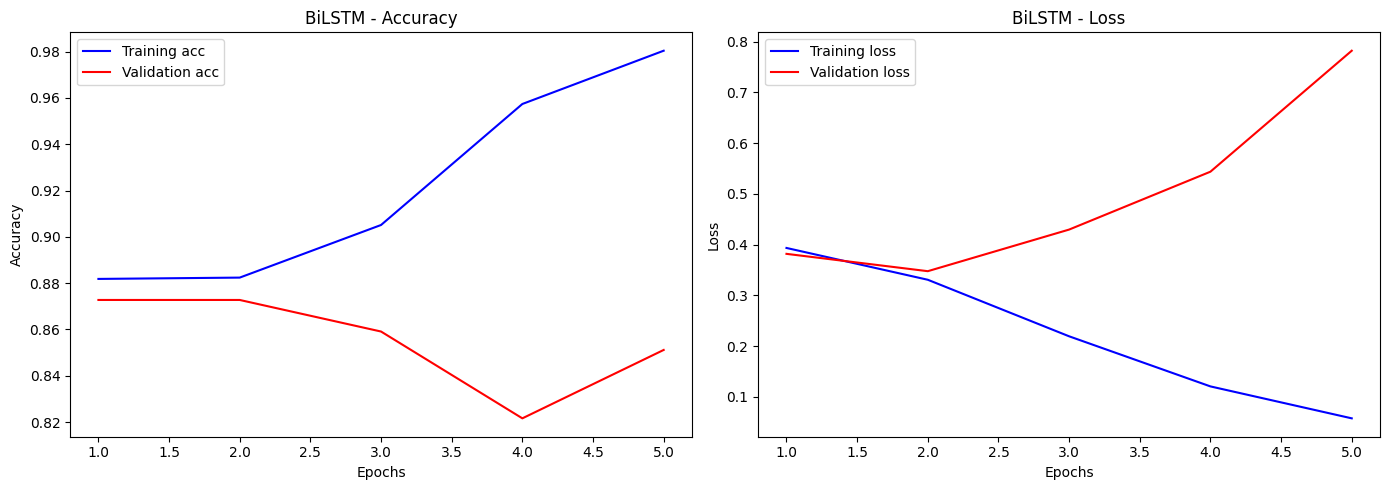

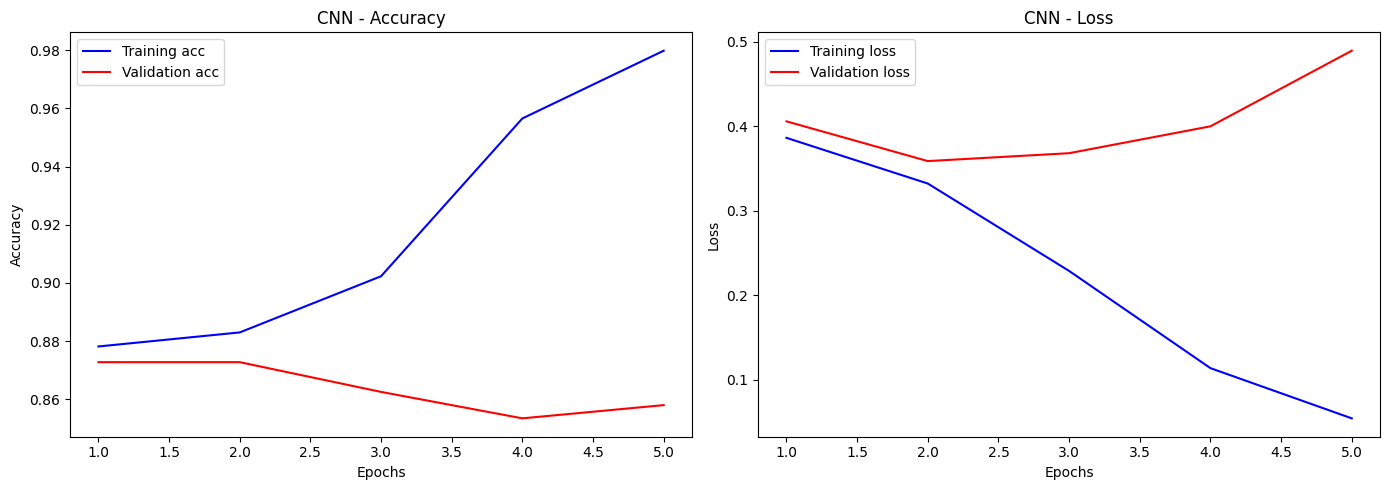

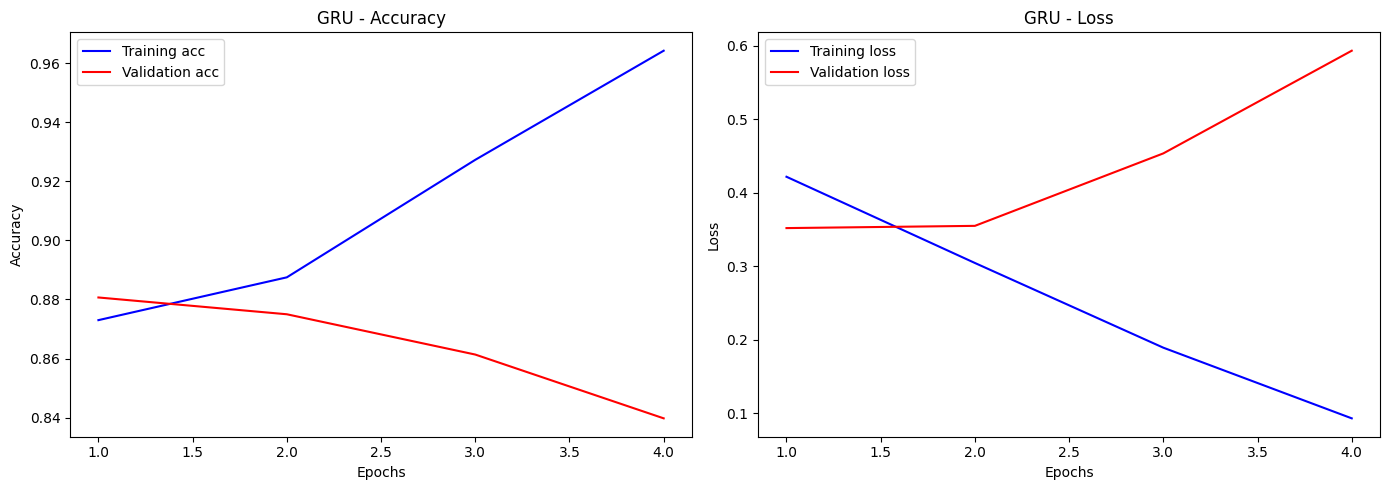

In [50]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call it for each model
plot_history(history_bilstm, "BiLSTM")
plot_history(history_cnn, "CNN")
plot_history(history_gru, "GRU")


###  2. Bar Chart Comparing Final Model Metrics

In [51]:
bilstm_metrics = model_bilstm.evaluate(X_val_b, y_val_b, verbose=0)
cnn_metrics = model_cnn.evaluate(X_val_b, y_val_b, verbose=0)
gru_metrics = model_gru.evaluate(X_val_b, y_val_b, verbose=0)


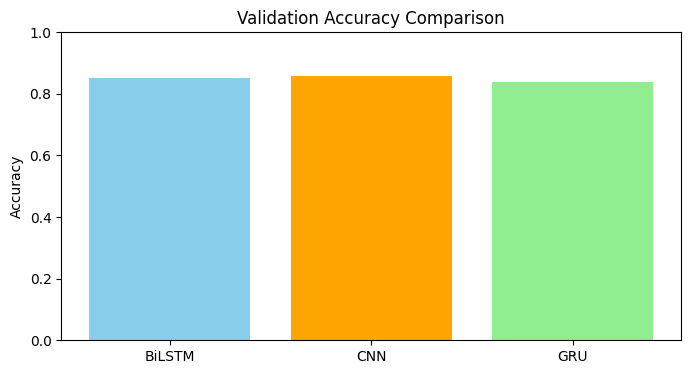

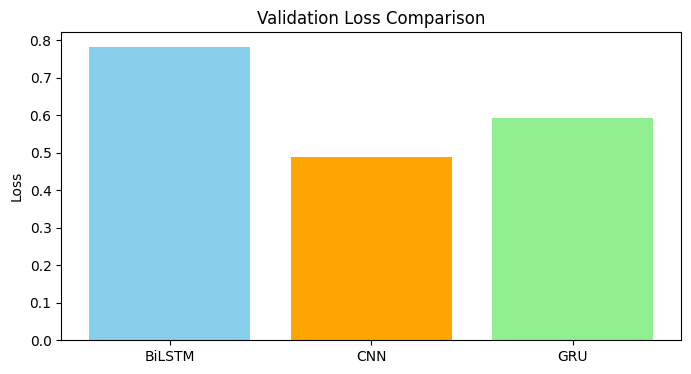

In [52]:
models = ['BiLSTM', 'CNN', 'GRU']
accuracy = [bilstm_metrics[1], cnn_metrics[1], gru_metrics[1]]
loss = [bilstm_metrics[0], cnn_metrics[0], gru_metrics[0]]

# Accuracy
plt.figure(figsize=(8, 4))
plt.bar(models, accuracy, color=['skyblue', 'orange', 'lightgreen'])
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Loss
plt.figure(figsize=(8, 4))
plt.bar(models, loss, color=['skyblue', 'orange', 'lightgreen'])
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.show()


### Plot Accuracy for Subtask A and B

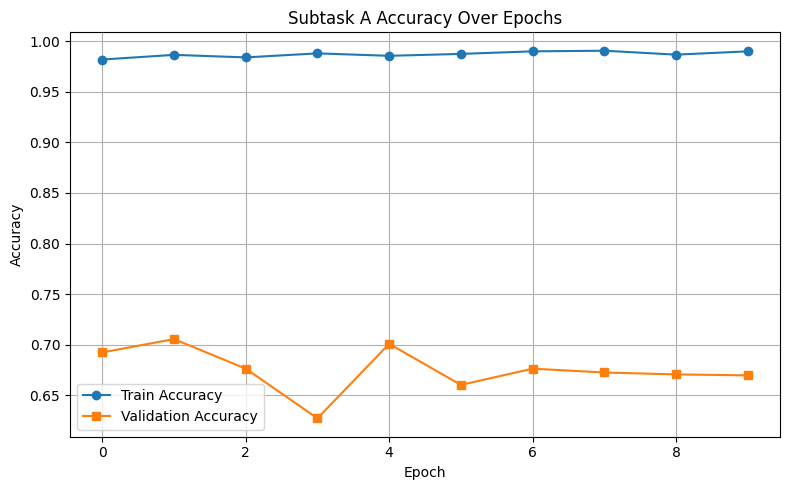

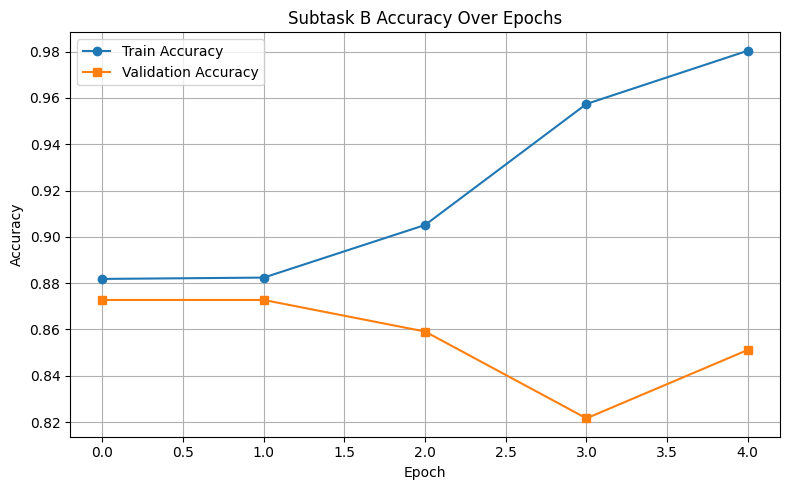

In [53]:
# Plot training and validation accuracy
def plot_accuracy(train_accuracies, val_accuracies=None, title='Model Accuracy'):
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    if val_accuracies:
        plt.plot(val_accuracies, label='Validation Accuracy', marker='s')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage (ensure you replace with actual values if variables are different)
# Assuming history_lstm, history_bilstm are your model history objects
train_accuracies = history_lstm.history['accuracy']
val_accuracies = history_lstm.history['val_accuracy']
train_accuracies_b = history_bilstm.history['accuracy']
val_accuracies_b = history_bilstm.history['val_accuracy']

plot_accuracy(train_accuracies, val_accuracies, title="Subtask A Accuracy Over Epochs")
plot_accuracy(train_accuracies_b, val_accuracies_b, title="Subtask B Accuracy Over Epochs")

### Plot Confusion Matrix for Both Subtasks

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


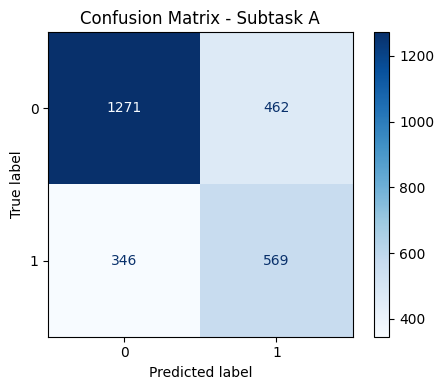

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


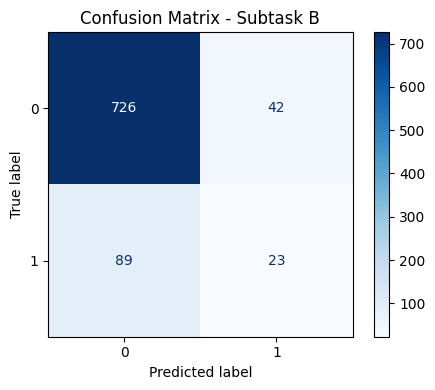

In [54]:
def plot_conf_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels) # Assuming labels=[0, 1] for numerical labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, cmap='Blues')
    plt.title(title)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Example usage for Subtask A
# Assuming you have X_test, y_test from the Subtask A section
y_pred_a = (model_lstm.predict(X_test) > 0.5).astype("int32")  # Assuming model_lstm is your Subtask A model
y_true_a = y_test  # Assuming y_test is your true labels for Subtask A
plot_conf_matrix(y_true_a, y_pred_a, labels=[0, 1], title='Confusion Matrix - Subtask A') # Change labels to [0, 1]

# Example usage for Subtask B
# Assuming you have X_val_b, y_val_b from the Subtask B section
y_pred_b = (model_bilstm.predict(X_val_b) > 0.5).astype("int32") # Assuming model_bilstm is your Subtask B model
y_true_b = y_val_b  # Assuming y_val_b is your true labels for Subtask B
plot_conf_matrix(y_true_b, y_pred_b, labels=[0, 1], title='Confusion Matrix - Subtask B') # Change labels to [0, 1]